 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 6. MLP Basis**
# Section 8. Tensorflow을 이용한 Network Training

### _Objective_
1. Tensorflow의 Low-API부터 High-API까지의 메소드들을 통해, 우리가 구성한 신경망을 학습시켜보도록 하겠습니다. <br>
  
╚═════════════════════════════════════════╝

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf
tf.random.set_random_seed(252)
np.random.seed(100)

from tqdm import tqdm
import matplotlib.pyplot as plt

### [Optional.  Tensorflow Graph Visualization ]

---

> _Jupyter에서 Tensorflow에서 구성되는 Graph를 시각적으로 보여주기 위한 helper 메소드입니다._<br>

In [2]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## 예제 데이터 ) MNIST 데이터셋

MNIST 데이터셋은 가장 대표적인 머신러닝 데이터 셋 중 하나입니다.<br>
0~9까지의 숫자가 28x28 픽셀에 위치합니다.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### MNIST 시각화

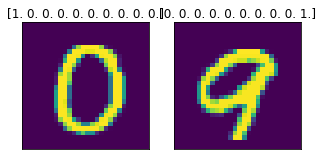

In [4]:
fig = plt.figure(figsize=(5,5))

label = mnist.train.labels[10]
image = mnist.train.images[10]

ax = fig.add_subplot(1,2,1)
ax.set_title(str(label))
ax.set_xticks([])
ax.set_yticks([])    
ax.imshow(image.reshape(28,28))

label = mnist.train.labels[17]
image = mnist.train.images[17]

ax = fig.add_subplot(1,2,2)
ax.set_title(str(label))
ax.set_xticks([])
ax.set_yticks([])    
ax.imshow(image.reshape(28,28))

plt.show()

<br><br>

# \[ 1. Tensorflow Graph 그리기 \]

----

----

> *MNIST를 학습시킬 신경망을 텐서플로우로 구현해보도록 하겠습니다.*<br>

<br>

## 1.  placeholder 생성

----

* 위의 모델을 학습시키고, 예측하기 위해서는<br>
  이미지(28x28=784), 라벨(label), 학습률(learning rate)을 받아오는 placeholder가 필요합니다.

In [5]:
num_inputs = 28*28 # MNIST Input size
num_outputs = 10 # The number of Label : 10

tf.reset_default_graph()

# Data를 받아오는 placeholder
x = tf.placeholder(tf.float32, shape=(None, num_inputs),
                   name='x')
labels = tf.placeholder(tf.float32, shape=(None, num_outputs),
                        name='labels')
learning_rate = tf.placeholder_with_default(0.01,shape=(),
                                            name='learning_rate')

<br>
## 2. 은닉층 생성
----
* 우리는 2개의 은닉층과 1개의 출력층으로 구성된 레이어를 구성해보도록 하겠습니다.

In [6]:
num_hidden1 = 300
num_hidden2 = 100

# Weight 초기화
with tf.variable_scope('hidden1'):
    w1 = tf.Variable(tf.random.normal([num_inputs,num_hidden1],
                                      stddev=0.1),
                     name='weight')
    b1 = tf.Variable(tf.zeros([num_hidden1])
                     ,name='bias')
    
    z1 = tf.matmul(x, w1) + b1
    a1 = tf.nn.relu(z1)

with tf.variable_scope('hidden2'):
    w2 = tf.Variable(tf.random.normal([num_hidden1,num_hidden2],
                                      stddev=0.1),
                     name='weight')
    b2 = tf.Variable(tf.zeros([num_hidden2])
                     ,name='bias')

    z2 = tf.matmul(a1, w2) + b2
    a2 = tf.nn.relu(z2)
    
with tf.variable_scope('output'):
    wo = tf.Variable(tf.random.normal([num_hidden2,num_outputs],
                                      stddev=0.1),
                     name='weight')
    bo = tf.Variable(tf.zeros([num_outputs])
                     ,name='bias')

    logits = tf.matmul(a2, wo) + bo
logits = tf.identity(logits, name='logits')


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
show_graph(tf.get_default_graph())

### (2) high-API로 보다 간단하게 구성하기

텐서플로우에서는 다양한 high-API를 제공합니다.<br>
우리는 위의 코드를 아래와 같이 간결하게 구성할 수 있습니다.

In [8]:
tf.reset_default_graph()

# Data를 받아오는 placeholder
x = tf.placeholder(tf.float32, shape=(None, num_inputs),
                   name='x')
labels = tf.placeholder(tf.float32, shape=(None, num_outputs),
                        name='labels')
learning_rate = tf.placeholder_with_default(0.01,shape=(),
                                            name='learning_rate')

a1 = tf.layers.Dense(num_hidden1,activation='relu',name='hidden1')(x)
a2 = tf.layers.Dense(num_hidden2,activation='relu',name='hidden2')(a1)
logits = tf.layers.Dense(num_outputs,name='output')(a2)
logits = tf.identity(logits,name='logits')

In [9]:
show_graph(tf.get_default_graph())

<br>
## 3. 손실함수 구현
----
* 2개 이상의 Multi-Class를 분류하는 문제에서는 주로 이전에 배운 `Softmax-with-CrossEntropy` Loss를 이용합니다. 정답값으로 `label`을 받고, 예측값으로 `logits`을 받아 계산합니다.

### (1) Softmax 함수

Softmax 함수는 Sigmoid 함수을 일반화한 함수입니다.<br>
Sigmoid 함수와 같이, 로짓 값을 확률로 변환하는 역할을 하는데,<br>
이진 분류가 아닌, **다중 클래스 분류**를 할 수 있다는 점에서 차이가 있습니다.

MNIST 데이터셋은 0~9까지 10개의 숫자 라벨로 나누어야 하는, **다중 클래스 분류** 문제입니다.<br>

![Imgur](https://i.imgur.com/8ORYj3v.png)

위와 같이 로짓 값을 확률 값으로 변환시켜 줍니다.<br>
softmax 함수는 아래와 같이 정의할 수 있습니다.

$$
softmax(z) = \frac{e^{z_i}}{\sum_{j=1}^{\mbox{클래스수}} e^{z_j}}
$$

### (2) Cross-Entropy 손실함수

![Imgur](https://i.imgur.com/xEKWsxD.png)

우리는 정답 값을 일반적으로 One-Hot Vector의 형태로 나타냅니다. <br>
이는 Softmax로 만들어진 확률값에 대응되는 것으로, <br>
특정 클래스만 1이고, 다른 클래스들은 0인 값으로 구성되어 있습니다다.<br>

Cross-Entropy 식은 <br>
이 확률값과 one-hot vector가 얼마나 차이가 나는지를 정의합니다. <br>


$$\mbox{Cross-Entropy } = \sum_{i=1}^{\mbox{클래스수}} y_{pred,i}log(y_{true,i})$$

### (3) 텐서플로우로 정의하기

In [10]:
loss = tf.losses.softmax_cross_entropy(labels,logits)

Instructions for updating:
Use tf.cast instead.


In [11]:
show_graph(tf.get_default_graph())

<br>
## 4. Graph만드는 메소드 구현
----
* 위의 Graph을 build하는 메소드는 아래와 같이 구성됩니다.


In [12]:
def build_graph():
    num_inputs = 28*28 # MNIST Input size
    num_outputs = 10 # The number of Label : 10

    num_hidden1 = 300
    num_hidden2 = 100

    graph = tf.Graph()
    with graph.as_default():
        # Data를 받아오는 placeholder
        x = tf.placeholder(tf.float32, shape=(None, num_inputs),
                           name='x')
        labels = tf.placeholder(tf.float32, shape=(None, num_outputs),
                                name='labels')
        learning_rate = tf.placeholder_with_default(0.01,shape=(),
                                                    name='learning_rate')
        
        a1 = tf.layers.Dense(num_hidden1,
                             activation='relu',
                             name='hidden1')(x)
        a2 = tf.layers.Dense(num_hidden2,
                             activation='relu',
                             name='hidden2')(a1)
        logits = tf.layers.Dense(num_outputs,
                                 name='output')(a2)
        logits = tf.identity(logits,name='logits')
        
        loss = tf.losses.softmax_cross_entropy(labels,logits)
    return graph

In [13]:
graph = build_graph()
show_graph(graph)

<br><br>

# \[ 2. Tensorflow의 Training 방식들 \]

----

----

> *Tensorflow에서는 Low-API부터 High-API까지 다양한 형태로 학습할 수있도록 
제공합니다. *<br>

<br>

## 1.  `tf.gradients`이용하기

----

* Tensorflow에서는 기본적으로 자동미분을 지원합니다.<br>
* 위의 방식을 통해, 우리는 간단하게 모든 weight들의 미분값을 계산할 수 있습니다.

In [14]:
graph = build_graph()

x = graph.get_tensor_by_name('x:0')
labels = graph.get_tensor_by_name('labels:0')
learning_rate = graph.get_tensor_by_name('learning_rate:0')
logits = graph.get_tensor_by_name('logits:0')

### (1) 학습시킬 Weights의 리스트 가져오기


In [15]:
weights = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
weights

[<tf.Variable 'hidden1/kernel:0' shape=(784, 300) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(300,) dtype=float32_ref>,
 <tf.Variable 'hidden2/kernel:0' shape=(300, 100) dtype=float32_ref>,
 <tf.Variable 'hidden2/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'output/kernel:0' shape=(100, 10) dtype=float32_ref>,
 <tf.Variable 'output/bias:0' shape=(10,) dtype=float32_ref>]

### (2) 신경망의 손실함수 가져오기

In [16]:
loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
loss

<tf.Tensor 'softmax_cross_entropy_loss/value:0' shape=() dtype=float32>

### (3) 자동미분을 통한 Gradient 계산하기

텐서플로우에서는 내장된 자동미분 기능이 있어, BackPropagation을 구현하지 않더라도,<br>
그래프 간 관계를 통해, BackPropagation을 자동으로 수행해 주는<br>
`tf.gradients`메소드를 지원합니다.

In [17]:
with graph.as_default():
    grad_weights = tf.gradients(loss, weights)
    grad_weights

In [18]:
show_graph(graph)

### (4) Gradient Descent 알고리즘 적용하기

In [19]:
with graph.as_default():
    with tf.variable_scope('gradient_descent'):
        assign_ops = []
        for weight, grad_weight in zip(weights,grad_weights):
            # weight 별 Gradient Descent 알고리즘 적용하기
            assign_op = tf.assign_sub(weight, grad_weight*learning_rate)
            assign_ops.append(assign_op)

        train_op = tf.group(assign_ops, name='train_op')

In [20]:
show_graph(graph)

### (5) 모델 학습시키기 

In [21]:
n_epochs = 40   # 총 학습 횟수
batch_size = 50 # 한번의 Loss를 계산할 때 쓰는 데이터의 갯수

with graph.as_default():
    sess = tf.Session(graph=graph)
    sess.run(tf.global_variables_initializer())
    
    for epoch in tqdm(range(n_epochs)):
        for step in range(mnist.train.num_examples // batch_size):
            x_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_op,feed_dict={
                x:x_batch,
                labels:y_batch
            })
            

100%|██████████| 40/40 [01:04<00:00,  1.60s/it]


### (6) 모델 결과 확인하기

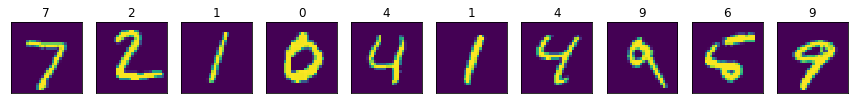

In [22]:
test_images = mnist.test.images[0:10]

logit_values = sess.run(logits,feed_dict={x:test_images})
predictions = logit_values.argmax(axis=1)


fig = plt.figure(figsize=(15,3))

for idx, (image, prediction) in enumerate(zip(test_images,predictions)):
    ax = fig.add_subplot(1,10,idx+1)
    
    ax.set_title(prediction)
    ax.set_xticks([])
    ax.set_yticks([])    
    ax.imshow(image.reshape(28,28))

<br>

## 2.  `tf.train` 이용하기

----

* Tensorflow에서는 방금까지 다루었던 과정을 보다 간단하게 만들기 위해, tf.train 모듈을 제공합니다.<br>
* Gradient Descent와 같은 머신러닝 학습 방식을 결정할 수 있고, 이러한 학습 방식에 따른 최적화 함수를 optimizer라 부릅니다.<br>

In [23]:
graph = build_graph()

x = graph.get_tensor_by_name('x:0')
labels = graph.get_tensor_by_name('labels:0')
learning_rate = graph.get_tensor_by_name('learning_rate:0')
logits = graph.get_tensor_by_name('logits:0')

### (1) Optimizer 호출하기

In [24]:
with graph.as_default():
    optim = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

Optimizer은 크게 3 단계로 구성됩니다.

1. `compute_gradients()`를 통해, gradient를 계산합니다.
2. gradient에 필요한 작업이 있다면, 수행합니다.
3. `apply_gradients()`를 통해, gradient을 Weight에 적용합니다.

### (2) Gradient 계산하기

In [25]:
with graph.as_default():
    loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
    weights = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    
    # tf.gradient과 유사한 기능을 합니다.
    grads_and_vars = optim.compute_gradients(loss, weights)

for grad, var in grads_and_vars:
    print(grad, var)

Tensor("gradients/hidden1/MatMul_grad/tuple/control_dependency_1:0", shape=(784, 300), dtype=float32) <tf.Variable 'hidden1/kernel:0' shape=(784, 300) dtype=float32_ref>
Tensor("gradients/hidden1/BiasAdd_grad/tuple/control_dependency_1:0", shape=(300,), dtype=float32) <tf.Variable 'hidden1/bias:0' shape=(300,) dtype=float32_ref>
Tensor("gradients/hidden2/MatMul_grad/tuple/control_dependency_1:0", shape=(300, 100), dtype=float32) <tf.Variable 'hidden2/kernel:0' shape=(300, 100) dtype=float32_ref>
Tensor("gradients/hidden2/BiasAdd_grad/tuple/control_dependency_1:0", shape=(100,), dtype=float32) <tf.Variable 'hidden2/bias:0' shape=(100,) dtype=float32_ref>
Tensor("gradients/output/MatMul_grad/tuple/control_dependency_1:0", shape=(100, 10), dtype=float32) <tf.Variable 'output/kernel:0' shape=(100, 10) dtype=float32_ref>
Tensor("gradients/output/BiasAdd_grad/tuple/control_dependency_1:0", shape=(10,), dtype=float32) <tf.Variable 'output/bias:0' shape=(10,) dtype=float32_ref>


### (3) Gradient 필요한 작업 적용하기

딥러닝 알고리즘 학습의 핵심은 `Gradient`에 있습니다.<br>
우리는 gradient을 통해, 보다 학습이 안정적으로 되도록, 혹은 빠르게 되도록<br>
변형할 수 있습니다.

아래는 대표적으로 Gradient가 너무 커져서, 학습이 잘못되는 것을 방지하기 위해<br>
gradient의 값을 제한하는 gradient clipping 예시입니다.

In [26]:
with graph.as_default():
    with tf.variable_scope('clipped_gradient'):
        capped_grads_and_vars = []
        for grad, var in grads_and_vars:
            # 값이 -10~10이상이 되지 못하도록 제한
            capped_grad = tf.clip_by_value(grad,-10.0,10.0)
            capped_grads_and_vars.append((capped_grad, var))

In [27]:
show_graph(graph)

### (4) 처리된 gradient로 경사하강법에 적용하기

위에서 처리된 gradient로 경사하강법에 적용합니다.

In [28]:
with graph.as_default():
    train_op = optim.apply_gradients(capped_grads_and_vars)

In [29]:
show_graph(graph)

### (5) 모델 학습시키기 

In [30]:
n_epochs = 40   # 총 학습 횟수
batch_size = 50 # 한번의 Loss를 계산할 때 쓰는 데이터의 갯수

with graph.as_default():
    sess = tf.Session(graph=graph)
    sess.run(tf.global_variables_initializer())
    
    for epoch in tqdm(range(n_epochs)):
        for step in range(mnist.train.num_examples // batch_size):
            x_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_op,feed_dict={
                x:x_batch,
                labels:y_batch
            })
            

100%|██████████| 40/40 [01:10<00:00,  1.76s/it]


### (6) 모델 결과 확인하기

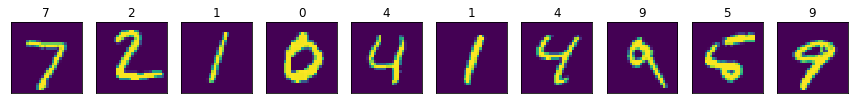

In [31]:
test_images = mnist.test.images[0:10]

logit_values = sess.run(logits,feed_dict={x:test_images})
predictions = logit_values.argmax(axis=1)

fig = plt.figure(figsize=(15,3))

for idx, (image, prediction) in enumerate(zip(test_images,predictions)):
    ax = fig.add_subplot(1,10,idx+1)
    ax.set_xticks([])
    ax.set_yticks([])    
    ax.set_title(prediction)
    ax.imshow(image.reshape(28,28))

---


<br>

## 3.  `minimize`을 이용한 Gradient Descent 계산

----

* optimizer에는 위의 과정을 간단히 하나의 메소드로 호출할 수 있도록 `Minimize`을 제공해줍니다.

In [32]:
graph = build_graph()

x = graph.get_tensor_by_name('x:0')
labels = graph.get_tensor_by_name('labels:0')
learning_rate = graph.get_tensor_by_name('learning_rate:0')
logits = graph.get_tensor_by_name('logits:0')

### (1) Minimize 메소드 호출하기

In [33]:
with graph.as_default():
    loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
    
    train_op = (tf.train
             .GradientDescentOptimizer(learning_rate=learning_rate)
             .minimize(loss))

In [34]:
show_graph(graph)

### (2) 모델 학습시키기

In [35]:
n_epochs = 40   # 총 학습 횟수
batch_size = 50 # 한번의 Loss를 계산할 때 쓰는 데이터의 갯수

with graph.as_default():
    sess = tf.Session(graph=graph)
    sess.run(tf.global_variables_initializer())
    
    for epoch in tqdm(range(n_epochs)):
        for step in range(mnist.train.num_examples // batch_size):
            x_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_op,feed_dict={
                x:x_batch,
                labels:y_batch
            })
            

100%|██████████| 40/40 [01:01<00:00,  1.54s/it]


### (3) 모델 결과 확인하기

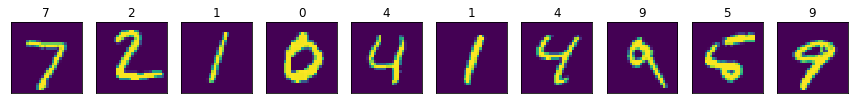

In [36]:
test_images = mnist.test.images[0:10]

logit_values = sess.run(logits,feed_dict={x:test_images})
predictions = logit_values.argmax(axis=1)

fig = plt.figure(figsize=(15,3))

for idx, (image, prediction) in enumerate(zip(test_images,predictions)):
    ax = fig.add_subplot(1,10,idx+1)
    ax.set_xticks([])
    ax.set_yticks([])    
    ax.set_title(prediction)
    ax.imshow(image.reshape(28,28))

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/01

---